<a href="https://colab.research.google.com/github/aaalexlit/tf-advanced-techniques-spec/blob/main/course_2_custom_distributed_training/Week2_Custom_training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from tqdm import tqdm
import tensorflow_datasets as tfds

# Load Fashion MNIST

In [2]:
train_data, info = tfds.load('fashion_mnist', split='train', with_info=True, 
                             data_dir='./data/')
test_data = tfds.load('fashion_mnist', split='test', data_dir='./data/')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteIZF8CQ/fashion_mnist-train.tfrecord*...:   0%|          | 0/60000…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteIZF8CQ/fashion_mnist-test.tfrecord*...:   0%|          | 0/10000 …

Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [23]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [24]:
def format_image(data):        
    image = data["image"]
    # Flatten the array
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [25]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

Shuffle and batch training data  
Batch test data

In [26]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size)

# Define the model

In [27]:
def base_model():
  inputs = Input(shape=(28*28, ), name='digits')
  x = Dense(64, activation='relu', name='dense_1')(inputs)
  x = Dense(64, activation='relu', name='dense_2')(x)
  outputs = Dense(10, activation='softmax', name='preds')(x)
  return Model(inputs=inputs, outputs=outputs)

# Define optimizer and loss funciton

In [28]:
optimizer = Adam()
loss_object = SparseCategoricalCrossentropy()

# Define Metrics

In [29]:
train_acc_metric = SparseCategoricalAccuracy()
val_acc_metric = SparseCategoricalAccuracy()

# Build training loop
1. use the model to calculate the logits on the set of inputs 
1. compute loss comparing the predicted outputs to the true outputs
1. calculate the gradients (ie partial derivatives of loss wrt each trainable weight)
1. update the trainable weights using the chosen optimizer algorithm 

In [30]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value

# Train for one epoch
1. Runs through all the batches
1. Updates trainable weigths on batch end
1. Updates and accumulates the values of the metrics
1. Displaying a progress bar using `tqdm`

In [31]:
number_of_training_batches = len(list(enumerate(train)))

In [32]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=number_of_training_batches,
              position=0,
              leave=True,
              bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
    logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
    losses.append(loss_value)

    train_acc_metric(y_batch_train, logits)

    pbar.set_description(f"Training loss for step {step}: {float(loss_value):.4f}")
    pbar.update()
  return losses


# Validate
1. Calculate loss on test dataset
1. Update the metrics

In [33]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
    val_logits = model(x_val)
    val_loss_value = loss_object(y_true=y_val, y_pred=val_logits)
    losses.append(val_loss_value)
    val_acc_metric(y_val, val_logits)
  return losses

# Define complete training loop
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.
6. Calculate the training and validation losses for the whole epoch at the end of the epoch

In [35]:
model = base_model()

epochs = 10
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
  print(f'Starting epoch {epoch}')
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val= perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = tf.reduce_mean(losses_train)
  losses_val_mean = tf.reduce_mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print(f'\n Epoch {epoch}: Train loss: {losses_train_mean:.4f}  Validation Loss: {losses_val_mean:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy {val_acc:.4f}')

  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Starting epoch 0


Training loss for step 937: 0.3871: 100%|██████████| 938/938 



 Epoch 0: Train loss: 0.4878  Validation Loss: 0.4227, Train Accuracy: 0.8193, Validation Accuracy 0.8458
Starting epoch 1


Training loss for step 937: 0.1617: 100%|██████████| 938/938 



 Epoch 1: Train loss: 0.3686  Validation Loss: 0.3937, Train Accuracy: 0.8675, Validation Accuracy 0.8594
Starting epoch 2


Training loss for step 937: 0.2455: 100%|██████████| 938/938 



 Epoch 2: Train loss: 0.3354  Validation Loss: 0.3912, Train Accuracy: 0.8788, Validation Accuracy 0.8596
Starting epoch 3


Training loss for step 937: 0.0727: 100%|██████████| 938/938 



 Epoch 3: Train loss: 0.3152  Validation Loss: 0.4003, Train Accuracy: 0.8849, Validation Accuracy 0.8601
Starting epoch 4


Training loss for step 937: 0.0793: 100%|██████████| 938/938 



 Epoch 4: Train loss: 0.3036  Validation Loss: 0.3590, Train Accuracy: 0.8883, Validation Accuracy 0.8713
Starting epoch 5


Training loss for step 937: 0.3079: 100%|██████████| 938/938 



 Epoch 5: Train loss: 0.2909  Validation Loss: 0.3603, Train Accuracy: 0.8930, Validation Accuracy 0.8735
Starting epoch 6


Training loss for step 937: 0.4446: 100%|██████████| 938/938 



 Epoch 6: Train loss: 0.2831  Validation Loss: 0.3534, Train Accuracy: 0.8947, Validation Accuracy 0.8764
Starting epoch 7


Training loss for step 937: 0.2175: 100%|██████████| 938/938 



 Epoch 7: Train loss: 0.2734  Validation Loss: 0.3730, Train Accuracy: 0.8989, Validation Accuracy 0.8707
Starting epoch 8


Training loss for step 937: 0.0760: 100%|██████████| 938/938 



 Epoch 8: Train loss: 0.2640  Validation Loss: 0.3741, Train Accuracy: 0.9028, Validation Accuracy 0.8721
Starting epoch 9


Training loss for step 937: 0.1868: 100%|██████████| 938/938 



 Epoch 9: Train loss: 0.2586  Validation Loss: 0.3641, Train Accuracy: 0.9033, Validation Accuracy 0.8799


# Evaluate model
Plot loss vs epochs

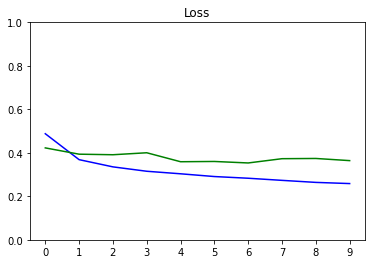

In [40]:
def plot_metrics(train_metric, val_metric, metric_name, ylim=1.0):
  plt.title(metric_name)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss")

In [41]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

(10000, 784)
10000


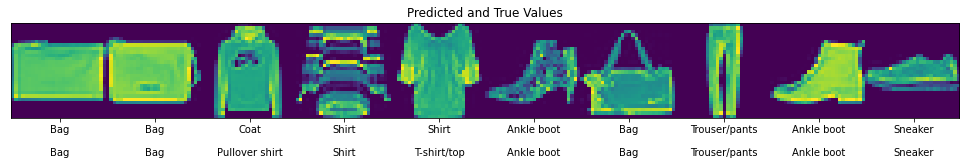

In [46]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  print(x.shape)
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

print(len(y_pred_batches))
indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)